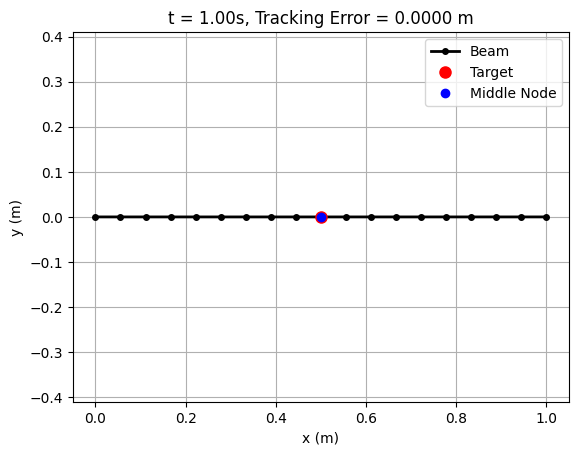

Step 1/1000, t = 1.00s, Err = 0.0000 m


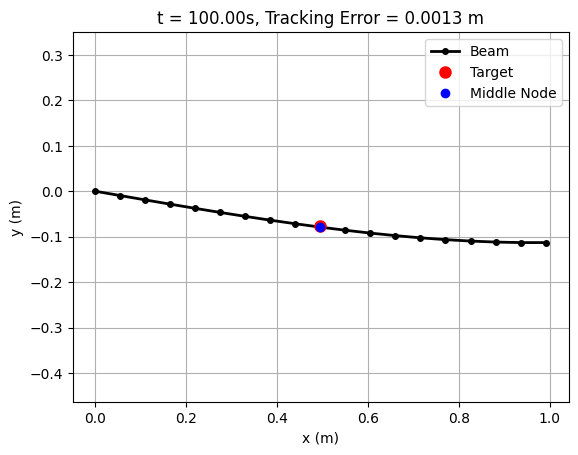

Step 100/1000, t = 100.00s, Err = 0.0013 m


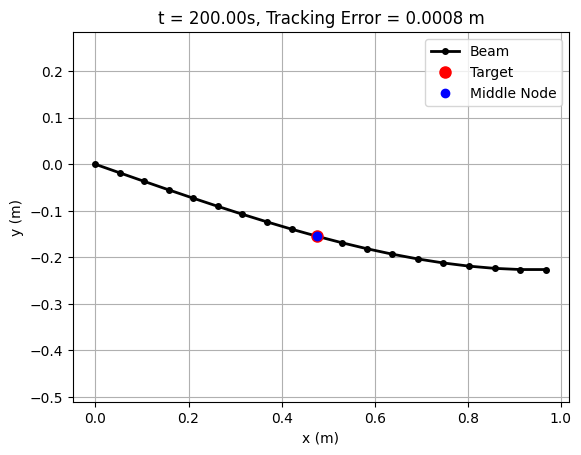

Step 200/1000, t = 200.00s, Err = 0.0008 m


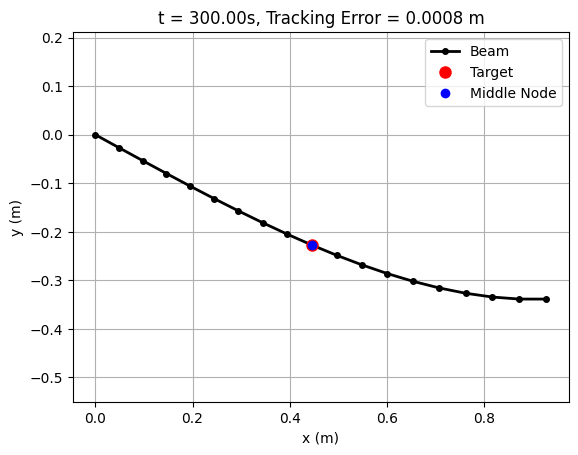

Step 300/1000, t = 300.00s, Err = 0.0008 m


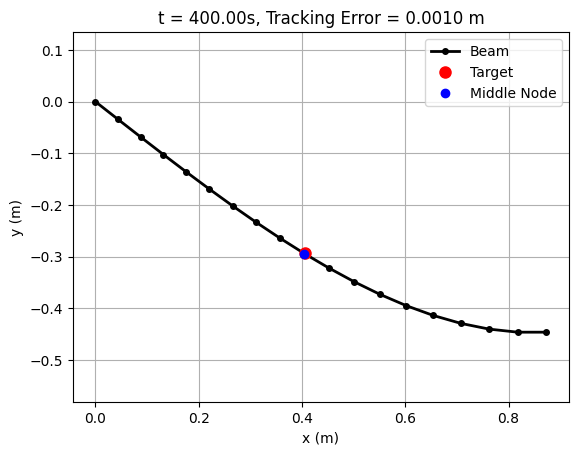

Step 400/1000, t = 400.00s, Err = 0.0010 m


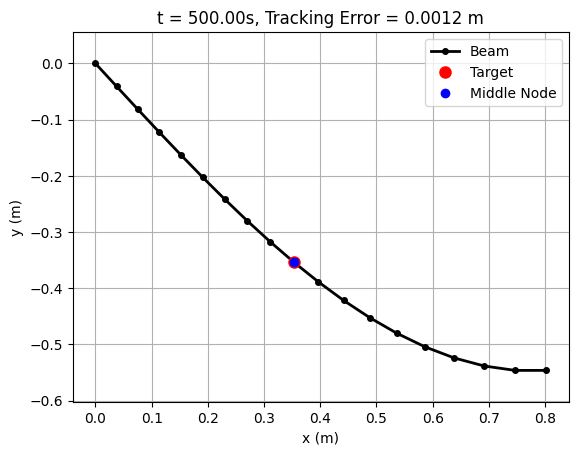

Step 500/1000, t = 500.00s, Err = 0.0012 m


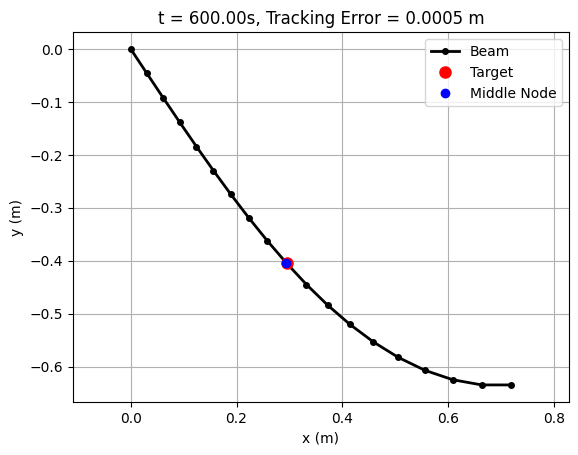

Step 600/1000, t = 600.00s, Err = 0.0005 m


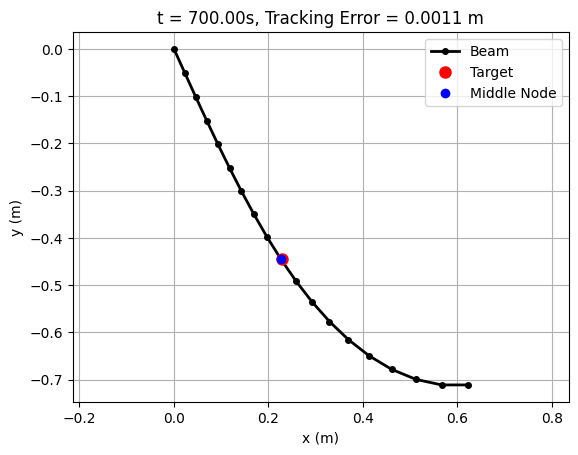

Step 700/1000, t = 700.00s, Err = 0.0011 m


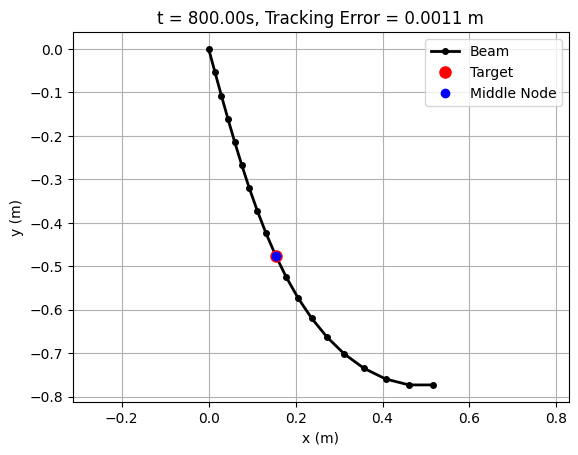

Step 800/1000, t = 800.00s, Err = 0.0011 m


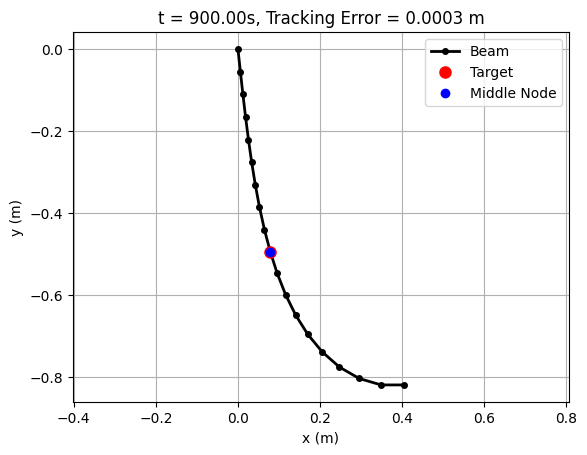

Step 900/1000, t = 900.00s, Err = 0.0003 m


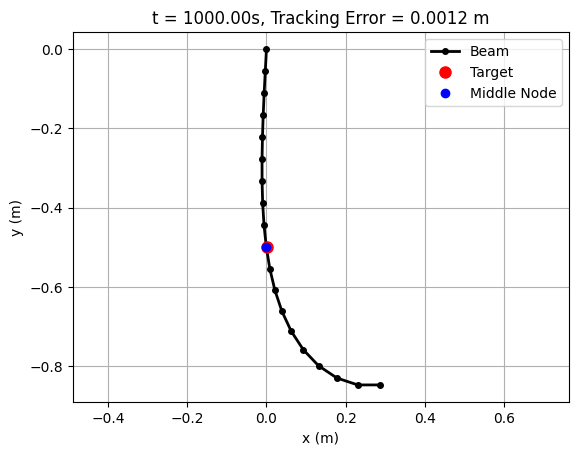

Step 1000/1000, t = 1000.00s, Err = 0.0012 m


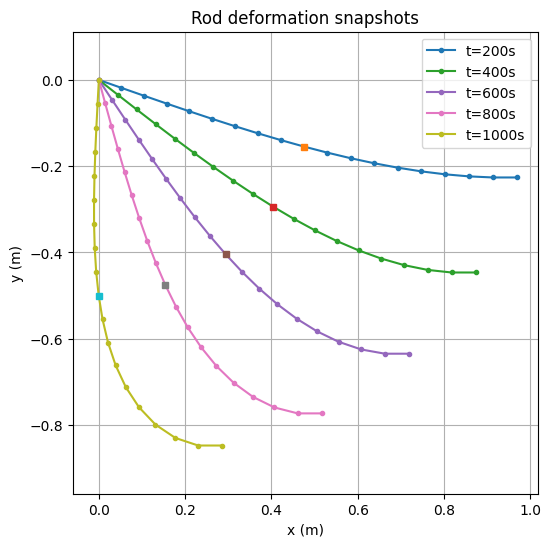

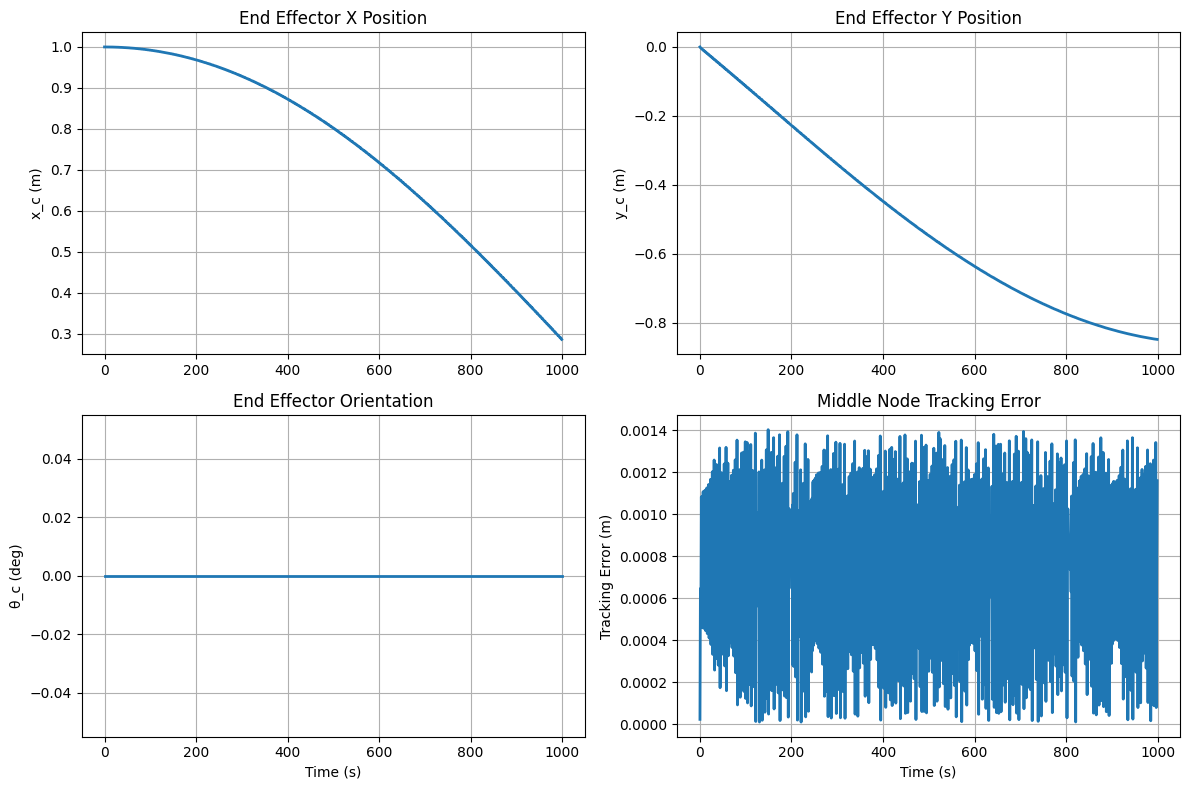

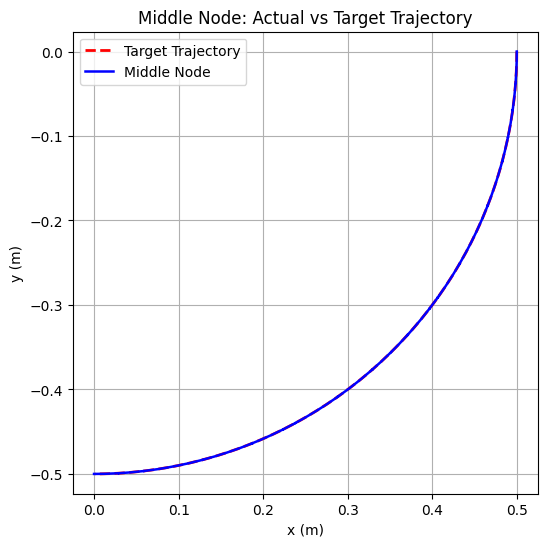

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Helper: cross product matrix
# =========================
def crossMat(a):
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])
    return A

# =========================
# Elastic energies: bending (grad & hess)
# =========================
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))
    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k
    return dF

def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0.0])
    node2 = np.array([xkp1, ykp1, 0.0])

    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])

    kappaBar = curvature0
    gradKappa = np.zeros(6)

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))
    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = kb[2]
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    DDkappa1 = np.zeros((6, 6))
    norm2_e = norm_e**2
    norm2_f = norm_f**2
    Id3 = np.eye(3)

    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)

    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  te_c_d2t_o_tt.T - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    dkappa = kappa1 - kappaBar
    dJ = (EI / l_k) * np.outer(gradKappa, gradKappa)
    dJ += (EI / l_k) * dkappa * DDkappa1
    return dJ

# =========================
# Elastic energies: stretching (grad & hess)
# =========================
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    F = np.zeros(4)
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = np.sqrt(dx*dx + dy*dy)

    # Avoid divide by zero in degenerate case
    if L == 0:
        return F

    coeff = -(1.0 - L / l_k) * (L**-1) / l_k
    F[0] = coeff * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = coeff * (-2.0 * ykp1 + 2.0 * yk)
    F[2] = coeff * ( 2.0 * xkp1 - 2.0 * xk)
    F[3] = coeff * ( 2.0 * ykp1 - 2.0 * yk)
    F *= 0.5 * EA * l_k
    return F

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    dx = xkp1 - xk
    dy = ykp1 - yk
    r2 = dx*dx + dy*dy
    L = np.sqrt(r2)

    J = np.zeros((4, 4))
    if L == 0:
        return J

    # Precompute common terms
    J11 = (1 / r2 / l_k**2 * (-2* xkp1 + 2* xk)**2) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * ((-2* xkp1 + 2* xk)**2) / 2 - 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k
    J12 = (1 / r2 / l_k**2 * (-2* ykp1 + 2* yk) * (-2* xkp1 + 2* xk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (-2* xkp1 + 2* xk) * (-2* ykp1 + 2* yk) / 2
    J13 = (1 / r2 / l_k**2 * ( 2* xkp1 - 2* xk) * (-2* xkp1 + 2* xk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (-2* xkp1 + 2* xk) * ( 2* xkp1 - 2* xk) / 2 + 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k
    J14 = (1 / r2 / l_k**2 * ( 2* ykp1 - 2* yk) * (-2* xkp1 + 2* xk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (-2* xkp1 + 2* xk) * ( 2* ykp1 - 2* yk) / 2
    J22 = (1 / r2 / l_k**2 * (-2* ykp1 + 2* yk)**2) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * ((-2* ykp1 + 2* yk)**2) / 2 - 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k
    J23 = (1 / r2 / l_k**2 * ( 2* xkp1 - 2* xk) * (-2* ykp1 + 2* yk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (-2* ykp1 + 2* yk) * ( 2* xkp1 - 2* xk) / 2
    J24 = (1 / r2 / l_k**2 * ( 2* ykp1 - 2* yk) * (-2* ykp1 + 2* yk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (-2* ykp1 + 2* yk) * ( 2* ykp1 - 2* yk) / 2 + 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k
    J33 = (1 / r2 / l_k**2 * ( 2* xkp1 - 2* xk)**2) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (( 2* xkp1 - 2* xk)**2) / 2 - 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k
    J34 = (1 / r2 / l_k**2 * ( 2* ykp1 - 2* yk) * ( 2* xkp1 - 2* xk)) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * ( 2* xkp1 - 2* xk) * ( 2* ykp1 - 2* yk) / 2
    J44 = (1 / r2 / l_k**2 * ( 2* ykp1 - 2* yk)**2) / 2 + (1 - L/l_k) * (r2 ** (-3/2)) / l_k * (( 2* ykp1 - 2* yk)**2) / 2 - 2 * (1 - L/l_k) * (r2 ** (-1/2)) / l_k

    J = np.array([[J11, J12, J13, J14],
                  [J12, J22, J23, J24],
                  [J13, J23, J33, J34],
                  [J14, J24, J34, J44]])
    J *= 0.5 * EA * l_k
    return J

# =========================
# Assemble elastic forces / jacobians
# =========================
def getFs(q, EA, deltaL):
    ndof = q.size
    N = ndof // 2
    Fs = np.zeros(ndof)
    Js = np.zeros((ndof, ndof))

    for k in range(0, N-1):
        xkm1 = q[2*k]
        ykm1 = q[2*k+1]
        xk = q[2*k+2]
        yk = q[2*k+3]
        ind = np.arange(2*k, 2*k+4)
        gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
        hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)
        Fs[ind] -= gradEnergy
        Js[np.ix_(ind, ind)] -= hessEnergy
    return Fs, Js

def getFb(q, EI, deltaL):
    ndof = q.size
    N = ndof // 2
    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    for k in range(1, N-1):
        xkm1 = q[2*k-2]
        ykm1 = q[2*k-1]
        xk   = q[2*k]
        yk   = q[2*k+1]
        xkp1 = q[2*k+2]
        ykp1 = q[2*k+3]
        ind = np.arange(2*k-2, 2*k+4)
        gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, deltaL, EI)
        hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, deltaL, EI)
        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy
    return Fb, Jb

# =========================
# Implicit integrator objective
# =========================
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, EI, EA, W, C,
           deltaL, free_index):

    q_new = q_old.copy()
    iter_count = 0
    error = tol * 10
    flag = 1

    while error > tol:
        F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt**2

        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        Fv = - C @ (q_new - q_old) / dt
        Jv = - C / dt

        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv

        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton step
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] -= dq_free

        error = np.linalg.norm(f_free)
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1
            print("Maximum number of iterations reached.")
            return q_new, flag

    return q_new, flag

# =========================
# PID control for end effector
# =========================
def compute_control_inputs(x_star, y_star, x_mid, y_mid,
                           x_mid_prev, y_mid_prev,
                           x_c_prev, y_c_prev,
                           integral_error, dt,
                           Kp, Ki, Kd):
    ex = x_star - x_mid
    ey = y_star - y_mid

    ex_dot = (x_mid - x_mid_prev) / dt
    ey_dot = (y_mid - y_mid_prev) / dt

    integral_error[0] += ex * dt
    integral_error[1] += ey * dt

    dx_c = Kp * ex + Ki * integral_error[0] - Kd * ex_dot
    dy_c = Kp * ey + Ki * integral_error[1] - Kd * ey_dot

    x_c_new = x_c_prev + dx_c
    y_c_new = y_c_prev + dy_c
    thetac_new = 0.0

    return x_c_new, y_c_new, thetac_new, integral_error

# =========================
# Plot helper for snapshots
# =========================
def plot_rod_deformation_history(snapshots, mid_idx):
    """
    Plot several snapshots of the rod shape collected as (time, q) tuples.
    mid_idx: index of the middle node (0-based for nodes, not DOFs)
    """
    plt.figure(figsize=(6, 6))
    for (t, q) in snapshots:
        x_arr = q[::2]
        y_arr = q[1::2]
        plt.plot(x_arr, y_arr, '-o', linewidth=1.5, markersize=3, label=f't={t:.0f}s')
        plt.plot(x_arr[mid_idx], y_arr[mid_idx], 's', markersize=5)
    plt.title('Rod deformation snapshots')
    plt.xlabel('x (m)'); plt.ylabel('y (m)')
    plt.axis('equal'); plt.grid(True)
    if len(snapshots) <= 10:
        plt.legend()
    plt.show()

# =========================
# Main setup
# =========================
nv = 19
ndof = 2 * nv
midNode = (nv + 1) // 2  # node index in 1-based; use (midNode-1) for 0-based

dt = 1.0
RodLength = 1.0

R_outer = 0.013
R_inner = 0.011
rho_metal = 2700.0
Y = 70e9

A = np.pi * (R_outer**2 - R_inner**2)
I_moment = np.pi/4.0 * (R_outer**4 - R_inner**4)

deltaL = RodLength / (nv - 1)
EI = Y * I_moment
EA = Y * A

maximum_iter = 1000
totalTime = 1000.0
plotStep = 100

tol = (EI / (RodLength ** 2)) * 1e-3

# Initial straight rod along x-axis
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * deltaL
    nodes[c, 1] = 0.0

# Mass vector & matrix
m = np.zeros(2 * nv)
node_mass = rho_metal * A * deltaL
for k in range(nv):
    m[2*k]   = node_mass
    m[2*k+1] = node_mass
mMat = np.diag(m)

# Gravity load W (constant)
W = np.zeros(2 * nv)
g = np.array([0.0, -9.81])
for k in range(nv):
    W[2*k]   = node_mass * g[0]
    W[2*k+1] = node_mass * g[1]

# Viscous damping (diagonal Stokes-like)
visc = 0.0
C = np.zeros((2 * nv, 2 * nv))
equiv_radius = np.sqrt(A/np.pi)
for k in range(nv):
    C[2*k, 2*k]     = 6.0 * np.pi * visc * equiv_radius
    C[2*k+1, 2*k+1] = 6.0 * np.pi * visc * equiv_radius

# Initial DOF vector & velocity
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2*c]   = nodes[c, 0]
    q0[2*c+1] = nodes[c, 1]
u0 = np.zeros(2 * nv)

# Boundary conditions (left fixed; right two nodes driven)
all_DOFs = np.arange(ndof)
fixed_left = np.array([0, 1])

# Control initial values
x_c = RodLength
y_c = 0.0
thetac = 0.0
x_mid_prev = q0[2*(midNode-1)]
y_mid_prev = q0[2*(midNode-1)+1]
integral_error = [0.0, 0.0]

# Time loop bookkeeping
Nsteps = int(round(totalTime / dt))
ctime = 0.0

x_star_history = np.zeros(Nsteps)
y_star_history = np.zeros(Nsteps)
snapshots = []
snapshot_times = [0, 200, 400, 600, 800, 1000]

# NEW: histories we actually fill every (successful) step
xc_history = []
yc_history = []
theta_c_history = []
mid_x_history = []
mid_y_history = []

# =========================
# Time integration loop
# =========================
for timeStep in range(1, Nsteps + 1):
    # Target motion
    x_star = RodLength/2.0 * np.cos(np.pi/2.0 * ctime/1000.0)
    y_star = -RodLength/2.0 * np.sin(np.pi/2.0 * ctime/1000.0)
    x_star_history[timeStep-1] = x_star
    y_star_history[timeStep-1] = y_star

    # Current middle node
    x_mid = q0[2*(midNode-1)]
    y_mid = q0[2*(midNode-1)+1]

    # PID update
    x_c, y_c, thetac, integral_error = compute_control_inputs(
        x_star, y_star, x_mid, y_mid,
        x_mid_prev, y_mid_prev,
        x_c, y_c, integral_error, dt,
        Kp=1.5, Ki=1.5, Kd=0.5
    )

    # Enforce max step on end effector movement
    max_step = 0.002
    dx = x_c - q0[2*(nv-1)]
    dy = y_c - q0[2*(nv-1)+1]
    move_mag = np.hypot(dx, dy)
    if move_mag > max_step:
        scale = max_step / move_mag
        x_c = q0[2*(nv-1)]   + dx * scale
        y_c = q0[2*(nv-1)+1] + dy * scale

    # Record control histories AFTER clamping (applied command)
    xc_history.append(x_c)
    yc_history.append(y_c)
    theta_c_history.append(thetac)

    # Update previous middle-node state for derivative term
    x_mid_prev, y_mid_prev = x_mid, y_mid

    # Impose right-end position/orientation via the last two nodes
    q0[2*(nv-1)]   = x_c
    q0[2*(nv-1)+1] = y_c
    q0[2*(nv-2)]   = x_c - deltaL * np.cos(thetac)
    q0[2*(nv-2)+1] = y_c - deltaL * np.sin(thetac)

    fixed_right = np.array([2*(nv-1), 2*(nv-1)+1,
                            2*(nv-2), 2*(nv-2)+1])
    current_fixed = np.concatenate((fixed_left, fixed_right))
    current_free = np.setdiff1d(all_DOFs, current_fixed)

    # Solve implicit step
    q_new, flag = objfun(q0, u0, dt, tol, maximum_iter,
                         m, mMat, EI, EA, W, C,
                         deltaL, current_free)

    if flag < 0:
        print(f"Convergence failed at step {timeStep}, t={ctime:.2f}s")
        break

    # Update kinematics
    u_new = (q_new - q0) / dt
    ctime += dt
    q0 = q_new.copy()
    u0 = u_new.copy()

    # Record middle node position history
    x_mid = q_new[2*(midNode-1)]
    y_mid = q_new[2*(midNode-1)+1]
    mid_x_history.append(x_mid)
    mid_y_history.append(y_mid)

    # Save snapshots at requested times
    if any(abs(ctime - t) < dt/2 for t in snapshot_times):
        snapshots.append((ctime, q_new.copy()))

    # Live plot every plotStep (optional)
    if timeStep % plotStep == 0 or timeStep == 1 or timeStep == Nsteps:
        x_arr = q_new[::2]
        y_arr = q_new[1::2]
        err = np.hypot(x_star - x_mid, y_star - y_mid)

        plt.figure(1)
        plt.clf()
        plt.plot(x_arr, y_arr, 'ko-', linewidth=2, markersize=4, label='Beam')
        plt.plot(x_star, y_star, 'ro', markersize=8, label='Target')
        plt.plot(x_mid, y_mid, 'bo', markersize=6, label='Middle Node')
        plt.title(f't = {ctime:.2f}s, Tracking Error = {err:.4f} m')
        plt.xlabel('x (m)'); plt.ylabel('y (m)')
        plt.axis('equal'); plt.grid(True); plt.legend()
        plt.show()

        print(f"Step {timeStep}/{Nsteps}, t = {ctime:.2f}s, Err = {err:.4f} m")

# =========================
# Post-run plots
# =========================
n_out = len(mid_x_history)
if n_out == 0:
    print("No output steps recorded; plotting skipped.")
else:
    t_axis = np.arange(n_out) * dt

    # 1) Deformation history snapshots
    if snapshots:
        plot_rod_deformation_history(snapshots, midNode-1)

    # 2) Control inputs over time
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(t_axis, np.array(xc_history)[:n_out], linewidth=2)
    axes[0, 0].set_ylabel('x_c (m)')
    axes[0, 0].set_title('End Effector X Position')
    axes[0, 0].grid(True)

    axes[0, 1].plot(t_axis, np.array(yc_history)[:n_out], linewidth=2)
    axes[0, 1].set_ylabel('y_c (m)')
    axes[0, 1].set_title('End Effector Y Position')
    axes[0, 1].grid(True)

    axes[1, 0].plot(t_axis, np.degrees(np.array(theta_c_history)[:n_out]), linewidth=2)
    axes[1, 0].set_ylabel('θ_c (deg)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_title('End Effector Orientation')
    axes[1, 0].grid(True)

    # 3) Tracking error over time (align with recorded steps)
    x_star_hist_trim = x_star_history[:n_out]
    y_star_hist_trim = y_star_history[:n_out]
    mid_x_history = np.array(mid_x_history)
    mid_y_history = np.array(mid_y_history)

    tracking_error = np.sqrt((x_star_hist_trim - mid_x_history)**2 +
                             (y_star_hist_trim - mid_y_history)**2)
    axes[1, 1].plot(t_axis, tracking_error, linewidth=2)
    axes[1, 1].set_ylabel('Tracking Error (m)')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_title('Middle Node Tracking Error')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4) XY trajectory comparison
    plt.figure(figsize=(6, 6))
    plt.plot(x_star_hist_trim, y_star_hist_trim, 'r--', linewidth=2, label='Target Trajectory')
    plt.plot(mid_x_history, mid_y_history, 'b-', linewidth=1.8, label='Middle Node')
    plt.xlabel('x (m)'); plt.ylabel('y (m)')
    plt.title('Middle Node: Actual vs Target Trajectory')
    plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
